In [78]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set(color_codes=True)
from mpl_toolkits.basemap import Basemap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import KFold
from sklearn.metrics import log_loss

# Load Data into DataFrame

In [27]:
app_events = pd.read_csv("/Users/Tamara/Desktop/Capstone/app_events.csv")
app_labels = pd.read_csv("/Users/Tamara/Desktop/Capstone/app_labels.csv")
label_categories = pd.read_csv("/Users/Tamara/Desktop/Capstone/label_categories.csv")
phone= pd.read_csv("/Users/Tamara/Desktop/Capstone/phone_brand_device_model.csv")
events = pd.read_csv("/Users/Tamara/Desktop/Capstone/events.csv")
ga_train = pd.read_csv("/Users/Tamara/Desktop/Capstone/ga_train.csv")
ga_test = pd.read_csv("/Users/Tamara/Desktop/Capstone/ga_test.csv")
submission = pd.read_csv("/Users/Tamara/Desktop/Capstone/sample_submission.csv")

In [28]:
file_paths = list(map(lambda x: "/Users/Tamara/Desktop/Capstone/" + x + ".csv", ["app_events", "app_labels", "events", "ga_train", 
                                                           "label_categories"]))

In [29]:
data_sets = list(map(pd.read_csv, file_paths))

# EDA

#### APP_EVENTS

In [30]:
app_events.head()

,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


All app_events has the is_installed = 1

60% are inactive events and 40% are active ==> Focus on active

32% of devices has events => 60% of data should be matched using the brand/model only

In [31]:
print("All app events has is_installed = 1")
app_events.is_installed.value_counts()

All app events has is_installed = 1


1    32473067
Name: is_installed, dtype: int64

All apps are installed

Active apps


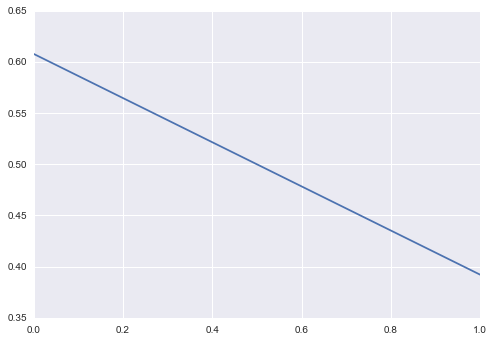

In [32]:
print ("Active apps")
active = app_events.is_active.value_counts()*1.0/len(app_events)
active
active.plot()

60% of apps are inactive

#### APP_LABELS

In [33]:
app_labels.head()

,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


In [34]:
label_categories.head()
label_categories['category'].value_counts()

unknown                             26
Pay                                  3
the film                             3
music                                3
Insurance                            3
Lottery ticket                       3
health                               3
Science and Technology               3
Financial Information                3
Furniture                            2
navigation                           2
Direct Banking                       2
Phone                                2
Hotels                               2
Reputation                           2
P2P                                  2
other                                2
the University                       2
Smart Shopping                       2
Mother                               2
notes                                2
Enthusiasm                           2
Total Cost                           2
entertainment                        2
Sports                               2
Car                      

#### LABEL CATEGORIES

In [35]:
label_categories.head()

,label_id,category
0,1,NaN
1,2,game-game type
2,3,game-Game themes
3,4,game-Art Style
4,5,game-Leisure time


#### PHONE

In [36]:
phone.head()

,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


In [37]:
print('{} rows'.format(phone.shape[0]))
print("unique values:")
for c in phone.columns:
    print('{}: {}'.format(c, phone[c].nunique()))

187245 rows
unique values:
device_id: 186716
phone_brand: 131
device_model: 1599


In [38]:
#Checking for duplicate device_ids
duplicate = phone.groupby('device_id').size()
duplicate = duplicate[duplicate>1]
duplicate.shape

(529,)

In [39]:
duplicate.value_counts()

2    529
dtype: int64

529 device ids have duplicate entries in phone dataframe. Are duplicate rows identical or different?

In [40]:
duplicate = phone.loc[phone.device_id.isin(duplicate.index)]
first = duplicate.groupby('device_id').first()
last = duplicate.groupby('device_id').last()

In [48]:
diff = (first != last).sum(axis=1).nonzero()
pd.concat((first.iloc[diff], last.iloc[diff]),axis=1)

,phone_brand,device_model,phone_brand,device_model
device_id,,,,
-7297178577997113203,华为,荣耀畅玩5X,华为,荣耀3C
-7059081542575379359,LG,Nexus 5,魅族,魅蓝Note 2
-6590454305031525112,小米,MI 3,华为,荣耀6 Plus
-5269721363279128080,三星,Galaxy Core Advance,小米,MI 3
-3004353610608679970,酷派,5891,酷派,7296
5245428108336915020,魅族,MX4,小米,MI One Plus


Looks like 1 device with duplicate rows have different values for brand and model. Are they in train or in test?

In [49]:
dev = _.index
print("in train: {}".format(sum(ga_train.device_id.isin(dev))))
print("in test: {}".format(sum(ga_train.device_id.isin(dev))))

in train: 1
in test: 1


In [50]:
#dropping the dulicates
phone = phone.drop_duplicates('device_id', keep='first')

In [51]:
# Checking to see if there are models belonging to different brands
c = phone.groupby('device_model')['phone_brand'].apply(pd.Series.nunique)
c.value_counts()

1    1545
2      43
3       8
4       3
Name: phone_brand, dtype: int64

In [52]:
# Some device models can belong to more than one brand. 
# So the correct way to label-encode device models is probably to concatenate with brand first.

lebrand = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = lebrand.transform(phone.phone_brand)
m = phone.phone_brand.str.cat(phone.device_model)
lemodel = LabelEncoder().fit(m)
phone['model'] = lemodel.transform(m)

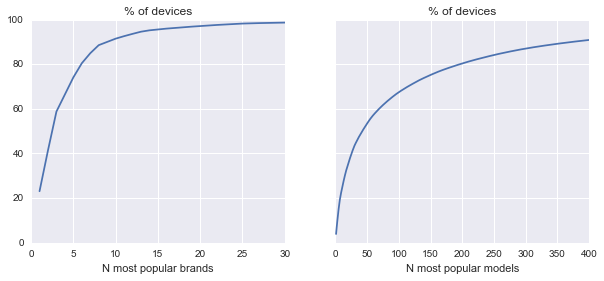

In [53]:
# Brand Popularity

c = phone.brand.value_counts()
s = c.cumsum()/c.sum()
fig, (ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(10,4))
ax1.plot(np.arange(s.shape[0])+1, s.values*100)
ax1.set_xlim(0,30)
ax1.set_xlabel('N most popular brands')
ax1.set_title('% of devices');
c = phone.model.value_counts()
s = c.cumsum()/c.sum()
ax2.plot(np.arange(s.shape[0])+1, s.values*100)
ax2.set_xlim(0,400)
ax2.set_xlabel('N most popular models')
ax2.set_title('% of devices');

9 most popular brands account for 90% of devices. For models the number to account for 90% of devices is 373.

#### Gender Ratio by Phone Brand

In [87]:
train = ga_train.merge(phone[['device_id','brand','model']], how='left',on='device_id')
train.head()

,device_id,gender,age,group,brand,model
0,-8076087639492063270,M,35,M32_M38,51,843
1,-2897161552818060146,M,35,M32_M38,51,843
2,-8260683887967679142,M,35,M32_M38,51,843
3,-4938849341048082022,M,30,M29_M31,51,865
4,245133531816851882,M,30,M29_M31,51,847


#### Age distributions by phone brand

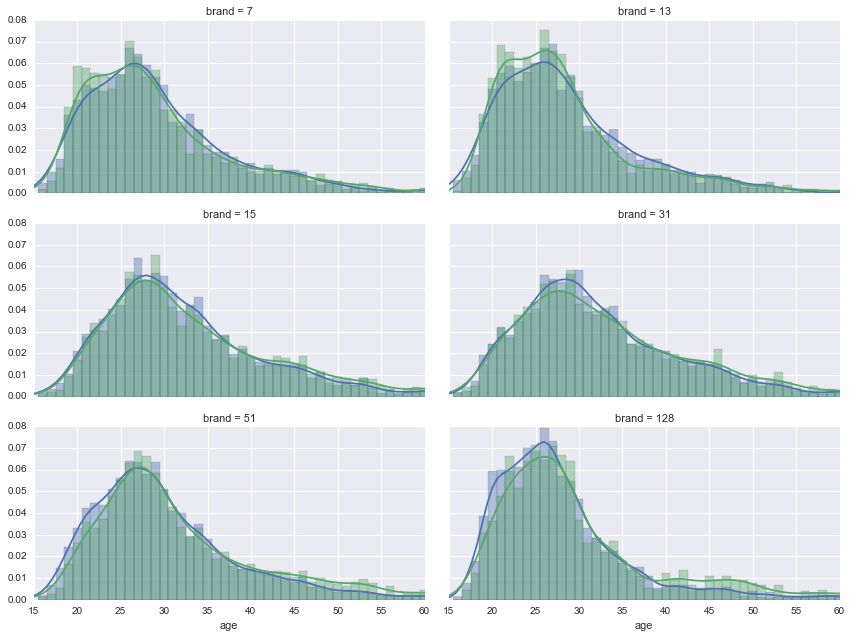

In [90]:
# the colors are gender
# the plots ar almost similar to one another
brands = train.brand.value_counts().index[:6]
c = train[train.brand.isin(brands)]
g = sns.FacetGrid(c, hue='gender', col='brand',col_wrap=2, aspect=2, xlim=(15,60))
g.map(sns.distplot, 'age', bins=np.arange(15,70)+0.5)

#### Age distributions by phone model

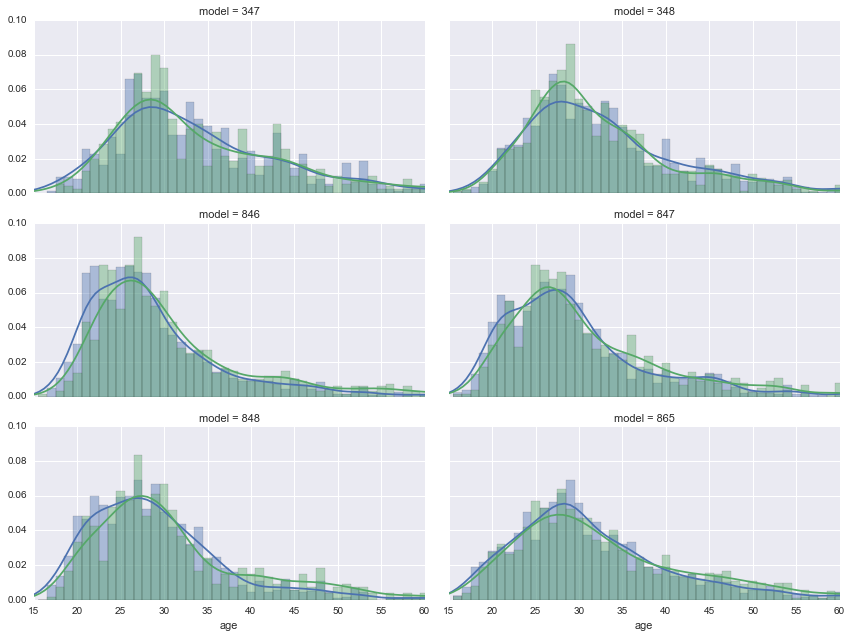

In [112]:
#Age distribution by model
# they also are almost similar to one another
models = train.model.value_counts().index[:6]
c = train[train.model.isin(models)]
g = sns.FacetGrid(c, hue='gender', col='model',col_wrap=2, aspect=2, xlim=(15,60))
g.map(sns.distplot, 'age', bins=np.arange(15,70)+0.5)

#### Benchmark: predict gender from phone brand

In [95]:
ptrain = ga_train.merge(phone[['device_id','brand','model']], how='left',on='device_id')
ptrain.head(3)

,device_id,gender,age,group,brand,model
0,-8076087639492063270,M,35,M32_M38,51,843
1,-2897161552818060146,M,35,M32_M38,51,843
2,-8260683887967679142,M,35,M32_M38,51,843


In [96]:
class GenderProb(object):
    def __init__(self, prior_weight=10.):
        self.prior_weight = prior_weight
    
    def fit(self, df, by):
        self.by = by
        self.label = 'pF_' + by
        self.prior = (df['gender']=='F').mean()
        # fit age groups
        prob = train.groupby(['gender','group']).size()
        pF = prob['F']/prob['F'].sum()
        pM = prob['M']/prob['M'].sum()
        self.agegroups = pd.concat((pF,pM),axis=0)
        # fit gender probs by grouping column
        c = (df[['gender']]=='F').groupby(df[by]).agg(['sum','count'])
        s = c[('gender','sum')]
        n = c[('gender','count')]
        prob = (s + self.prior*self.prior_weight) / (n + self.prior_weight)
        self.prob = pd.DataFrame(prob, columns=[self.label])
        return self
    
    def predict_proba(self, df):
        pF = df[[self.by]].merge(self.prob, how='left', 
                                left_on=self.by, right_index=True).fillna(self.prior)[self.label]
        pF = np.reshape(pF.values,(pF.shape[0],1))
        pred = np.zeros((df.shape[0],12))
        pred += self.agegroups.values
        pred[:,:6] *= pF
        pred[:,6:] *= 1-pF
        return pred

In [97]:
kf = KFold(ptrain.shape[0], n_folds=10, shuffle=True, random_state=0)
pred = np.zeros((ptrain.shape[0],n_classes))
for itrain, itest in kf:
    train = ptrain.iloc[itrain,:]
    test = ptrain.iloc[itest,:]
    ytrain, ytest = y[itrain], y[itest]
    clf = GenderProb().fit(train,'brand')
    pred[itest,:] = clf.predict_proba(test)
print(log_loss(y, pred))

2.42056997969


Wrap the scoring in a function to try different values for prior_weight.

In [98]:
def score(ptrain, by, prior_weight=10.):
    kf = KFold(ptrain.shape[0], n_folds=10, shuffle=True, random_state=0)
    pred = np.zeros((ptrain.shape[0],n_classes))
    for itrain, itest in kf:
        train = ptrain.iloc[itrain,:]
        test = ptrain.iloc[itest,:]
        ytrain, ytest = y[itrain], y[itest]
        clf = GenderProb(prior_weight=prior_weight).fit(train,by)
        pred[itest,:] = clf.predict_proba(test)
    return log_loss(y, pred)

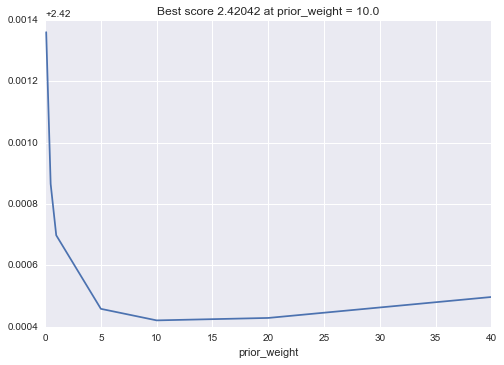

In [99]:
weights = [0.1, 0.5, 1., 5., 10., 20.,40.]
res = [score(ptrain,'brand',prior_weight=w) for w in weights]
plt.plot(weights, res)
plt.title('Best score {:.5f} at prior_weight = {}'.format(np.min(res),weights[np.argmin(res)]))
plt.xlabel('prior_weight')

### Benchmark: predict gender from device model

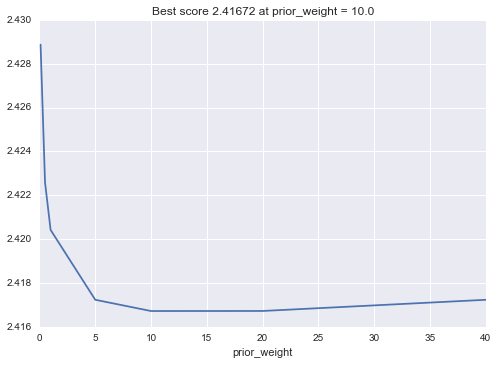

In [100]:
weights = [0.1, 0.5, 1., 5., 10., 20.,40.]
res = [score(ptrain,'model',prior_weight=w) for w in weights]
plt.plot(weights, res)
plt.title('Best score {:.5f} at prior_weight = {}'.format(np.min(res),weights[np.argmin(res)]))
plt.xlabel('prior_weight')

An improvement of about 0.01 when going from predicting class probabilities to predicting gender based on device model.

#### Benchmark: predict gender-age group from phone brand

In [101]:
class GenderAgeGroupProb(object):
    def __init__(self, prior_weight=10.):
        self.prior_weight = prior_weight
    
    def fit(self, df, by):
        self.by = by
        #self.label = 'pF_' + by
        self.prior = df['group'].value_counts().sort_index()/df.shape[0]
        # fit gender probs by grouping column
        c = df.groupby([by, 'group']).size().unstack().fillna(0)
        total = c.sum(axis=1)
        self.prob = (c.add(self.prior_weight*self.prior)).div(c.sum(axis=1)+self.prior_weight, axis=0)
        return self
    
    def predict_proba(self, df):
        pred = df[[self.by]].merge(self.prob, how='left', 
                                left_on=self.by, right_index=True).fillna(self.prior)[self.prob.columns]
        pred.loc[pred.iloc[:,0].isnull(),:] = self.prior
        return pred.values
    
def score(ptrain, by, prior_weight=10.):
    kf = KFold(ptrain.shape[0], n_folds=10, shuffle=True, random_state=0)
    pred = np.zeros((ptrain.shape[0],n_classes))
    for itrain, itest in kf:
        train = ptrain.iloc[itrain,:]
        test = ptrain.iloc[itest,:]
        ytrain, ytest = y[itrain], y[itest]
        clf = GenderAgeGroupProb(prior_weight=prior_weight).fit(train,by)
        pred[itest,:] = clf.predict_proba(test)
    return log_loss(y, pred)

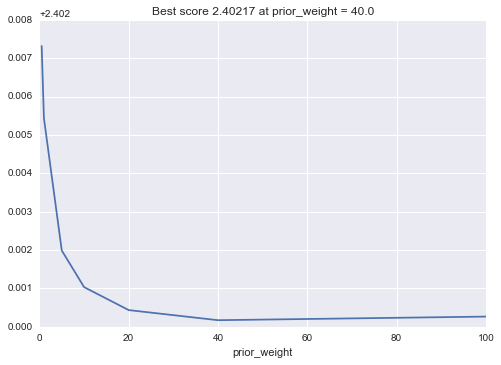

In [102]:
weights = [0.5, 1., 5., 10., 20.,40.,100.]
res = [score(ptrain,'brand',prior_weight=w) for w in weights]
plt.plot(weights, res)
plt.title('Best score {:.5f} at prior_weight = {}'.format(np.min(res),weights[np.argmin(res)]))
plt.xlabel('prior_weight')

### Benchmark: predict gender-age group from device model

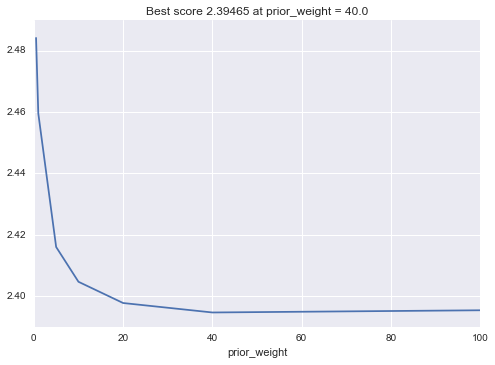

In [103]:
weights = [0.5, 1., 5., 10., 20.,40.,100.]
res = [score(ptrain,'model',prior_weight=w) for w in weights]
plt.plot(weights, res)
plt.title('Best score {:.5f} at prior_weight = {}'.format(np.min(res),weights[np.argmin(res)]))
plt.xlabel('prior_weight')

What if we combine predictions from phone brand and device model?

In [104]:
kf = KFold(ptrain.shape[0], n_folds=10, shuffle=True, random_state=0)
predb = np.zeros((ptrain.shape[0],n_classes))
predm = np.zeros((ptrain.shape[0],n_classes))
for itrain, itest in kf:
    train = ptrain.iloc[itrain,:]
    test = ptrain.iloc[itest,:]
    ytrain, ytest = y[itrain], y[itest]
    clf = GenderAgeGroupProb(prior_weight=40.).fit(train,'brand')
    predb[itest,:] = clf.predict_proba(test)
    clf = GenderAgeGroupProb(prior_weight=40.).fit(train,'model')
    predm[itest,:] = clf.predict_proba(test)
log_loss(y, 0.5*(predb+predm))

2.3909032414810976

Down at 2.391

# Submission

In [56]:
submission.head()

,device_id,F23-,F24-26,F27-28,F29-32,F33-42,F43+,M22-,M23-26,M27-28,M29-31,M32-38,M39+
0,1002079943728939269,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833
1,-1547860181818787117,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833
2,7374582448058474277,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833
3,-6220210354783429585,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833
4,-5893464122623104785,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833


In [57]:
submission.rename(columns = {'F23-':'F23','F24-26':'F24_F26', 'F27-28':'F27_F28', 
                      'F29-32':'F29_F32', 'F33-42':'F33_F42', 'F43+':'F43', 
                      'M22-':'M22', 'M23-26':'M23_M26', 'M27-28':'M27_M28', 
                      'M29-31':'M29_M31', 'M32-38':'M32_M38','M39+':'M39'}, inplace=True)


In [58]:
submission.head()

,device_id,F23,F24_F26,F27_F28,F29_F32,F33_F42,F43,M22,M23_M26,M27_M28,M29_M31,M32_M38,M39
0,1002079943728939269,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833
1,-1547860181818787117,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833
2,7374582448058474277,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833
3,-6220210354783429585,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833
4,-5893464122623104785,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833


In [106]:
ptest = ga_test.merge(phone[['device_id','brand','model']], how='left',on='device_id')
ptest.head(3)

,device_id,brand,model
0,1002079943728939269,51,857
1,-1547860181818787117,51,860
2,7374582448058474277,31,717


In [107]:
clf = GenderAgeGroupProb(prior_weight=40.).fit(ptrain,'brand')
predb = clf.predict_proba(ptest)
clf = GenderAgeGroupProb(prior_weight=40.).fit(ptrain,'model')
predm = clf.predict_proba(ptest)

In [111]:
pd.DataFrame(0.5*(predb+predm), 
             index = ptest.device_id, 
             columns=letarget.classes_).to_csv('pbm_subm.csv', index=True)


# EVENTS

In [59]:
events.head()

,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


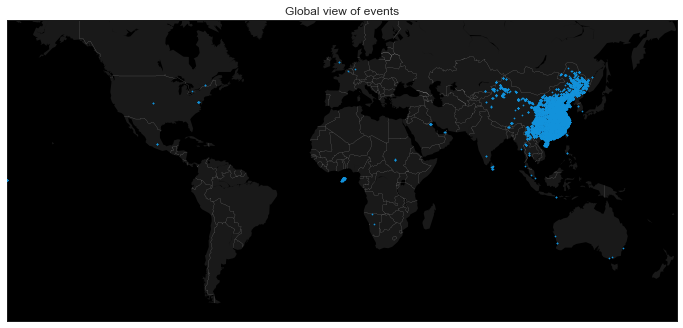

In [60]:
# Set up plot
events_sample = events.sample(n=100000)
plt.figure(1, figsize=(12,6))

# Mercator of World
m1 = Basemap(projection='merc',
             llcrnrlat=-60,
             urcrnrlat=65,
             llcrnrlon=-180,
             urcrnrlon=180,
             lat_ts=0,
             resolution='c')

m1.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m1.drawmapboundary(fill_color='#000000')                # black background
m1.drawcountries(linewidth=0.1, color="w")              # thin white line for country borders

# Plot the data
mxy = m1(events_sample["longitude"].tolist(), events_sample["latitude"].tolist())
m1.scatter(mxy[0], mxy[1], s=3, c="#1292db", lw=0, alpha=1, zorder=5)

plt.title("Global view of events")
plt.show()


Most of the events are located in China with a few sporadic ones around the globe.

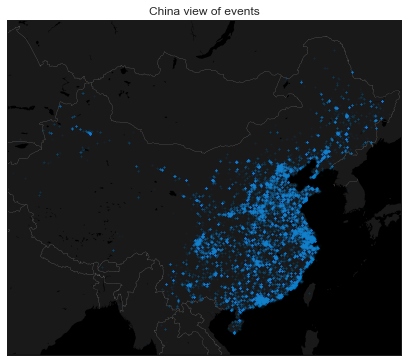

In [61]:
# Sample it down to only the China region
lon_min, lon_max = 75, 135
lat_min, lat_max = 15, 55

idx_china = (events["longitude"]>lon_min) &\
            (events["longitude"]<lon_max) &\
            (events["latitude"]>lat_min) &\
            (events["latitude"]<lat_max)

events_china = events[idx_china].sample(n=100000)

# Mercator of China
plt.figure(2, figsize=(12,6))

m2 = Basemap(projection='merc',
             llcrnrlat=lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=35,
             resolution='i')

m2.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m2.drawmapboundary(fill_color='#000000')                # black background
m2.drawcountries(linewidth=0.1, color="w")              # thin white line for country borders

# Plot the data
mxy = m2(events_china["longitude"].tolist(), events_china["latitude"].tolist())
m2.scatter(mxy[0], mxy[1], s=5, c="#1292db", lw=0, alpha=0.05, zorder=5)

plt.title("China view of events")
plt.show()

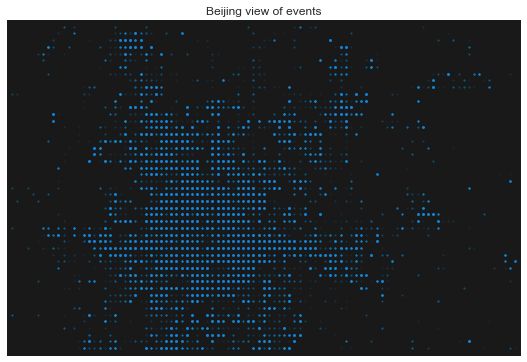

In [62]:
# Sample it down to only the Beijing region
lon_min, lon_max = 116, 117
lat_min, lat_max = 39.75, 40.25

idx_beijing = (events["longitude"]>lon_min) &\
              (events["longitude"]<lon_max) &\
              (events["latitude"]>lat_min) &\
              (events["latitude"]<lat_max)

events_beijing = events[idx_beijing]

# Mercator of Beijing
plt.figure(3, figsize=(12,6))

m3 = Basemap(projection='merc',
             llcrnrlat=lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=35,
             resolution='c')

m3.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m3.drawmapboundary(fill_color='#000000')                # black background
m3.drawcountries(linewidth=0.1, color="w")              # thin white line for country borders

# Plot the data
mxy = m3(events_beijing["longitude"].tolist(), events_beijing["latitude"].tolist())
m3.scatter(mxy[0], mxy[1], s=5, c="#1292db", lw=0, alpha=0.1, zorder=5)

plt.title("Beijing view of events")
plt.show()

At this scale, you can actually see the finite resolution of the lat/lon values.

# GA_TRAIN

In [63]:
ga_train.head()

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


In [64]:
print("Percentage of Male vs. Female")
ga_train.gender.value_counts()/len(ga_train)

Percentage of Male vs. Female


M    0.641758
F    0.358242
Name: gender, dtype: float64

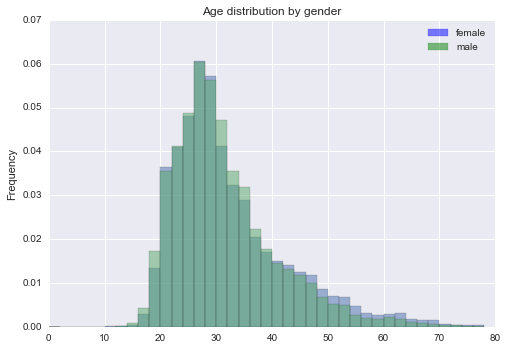

In [65]:
BINS = range(0,80,2)
ga_pivot = ga_train.loc[:,['gender','age']].pivot(columns = 'gender', values = 'age')

plt.figure()

age_female = ga_pivot['F'].plot.hist(normed = True, bins = BINS, alpha = 0.5)
age_female.set_title("Age distribution by gender")
age_male = ga_pivot['M'].plot.hist(normed = True, bins = BINS, alpha = 0.5)

female_patch = mpatches.Patch(color='blue', alpha = 0.5, label='female')
male_patch = mpatches.Patch(color='green', alpha = 0.5, label='male')
plt.legend(handles=[female_patch, male_patch])

plt.show()

In [66]:
print("Percentage distribution by group")
ga_train.group.value_counts().sort_values()/len(ga_train)

Percentage distribution by group


F27-28    0.041771
F24-26    0.056132
F43+      0.056186
F29-32    0.062000
F23-      0.067654
M27-28    0.072945
F33-42    0.074499
M29-31    0.097917
M22-      0.100315
M39+      0.114957
M32-38    0.126948
M23-26    0.128676
Name: group, dtype: float64

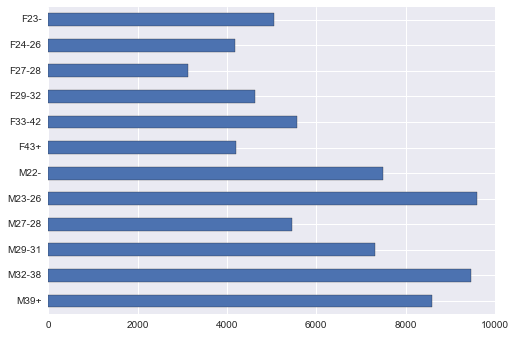

In [67]:
# Counts of target groups
ga_train.group.value_counts().sort_index(ascending=False).plot(kind='barh')

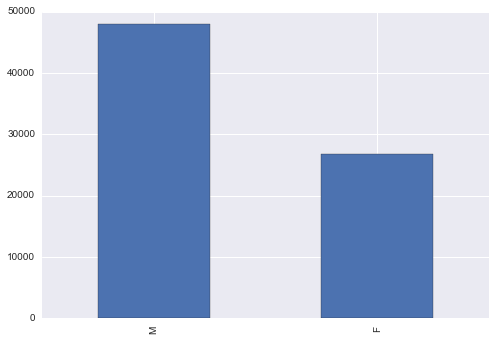

In [68]:
# Gender Counts
ga_train.gender.value_counts().plot(kind='bar')

Age distribution, lines denote target groups.

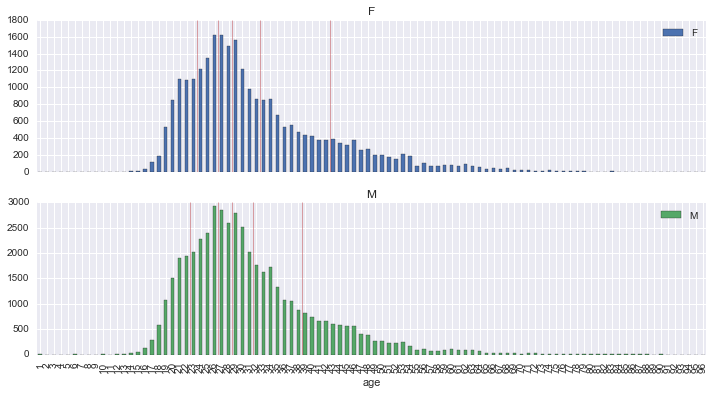

In [69]:
c = ga_train.groupby(['age','gender']).size().unstack().reindex(index=np.arange(ga_train.age.min(), ga_train.age.max()+1)).fillna(0)
ax1, ax2 = c.plot(kind='bar',figsize=(12,6),subplots=True);
ax1.vlines(np.array([23,26,28,32,42])-0.5,0,1800,alpha=0.5,linewidth=1,color='r')
ax2.vlines(np.array([22,26,28,31,38])-0.5,0,3000,alpha=0.5,linewidth=1,color='r')

In [70]:
ga_train['group'].replace({'F23-':'F23','F24-26':'F24_F26', 'F27-28':'F27_F28', 
                      'F29-32':'F29_F32', 'F33-42':'F33_F42', 'F43+':'F43', 
                      'M22-':'M22', 'M23-26':'M23_M26', 'M27-28':'M27_M28', 
                      'M29-31':'M29_M31', 'M32-38':'M32_M38','M39+':'M39'}, inplace=True)
ga_train.head()

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32_M38
1,-2897161552818060146,M,35,M32_M38
2,-8260683887967679142,M,35,M32_M38
3,-4938849341048082022,M,30,M29_M31
4,245133531816851882,M,30,M29_M31


In [71]:
print("Total users: ", len(ga_train))
print("\nUser group counts:")
ga_train["group"].value_counts()

('Total users: ', 74645)

User group counts:


M23_M26    9605
M32_M38    9476
M39        8581
M22        7488
M29_M31    7309
F33_F42    5561
M27_M28    5445
F23        5050
F29_F32    4628
F43        4194
F24_F26    4190
F27_F28    3118
Name: group, dtype: int64

# Testing

### 1/n_classes benchmark¶

In [72]:
letarget = LabelEncoder().fit(ga_train.group.values)
y = letarget.transform(ga_train.group.values)
n_classes = len(letarget.classes_)

In [73]:
pred = np.ones((ga_train.shape[0],n_classes))/n_classes
log_loss(y, pred)

2.4849066497880012

### Class probabilities benchmark

In [74]:
# This is the best we can do without any features
kf = KFold(ga_train.shape[0], n_folds=10, shuffle=True, random_state=0)
pred = np.zeros((ga_train.shape[0],n_classes))
for itrain, itest in kf:
    train = ga_train.iloc[itrain,:]
    test = ga_train.iloc[itest,:]
    ytrain, ytest = y[itrain], y[itest]
    prob = train.groupby('group').size()/train.shape[0]
    pred[itest,:] = prob.values
print(log_loss(y, pred))

2.42805122275


### APP IN USAGE BY GENDER AND AGE

# GA_TEST

In [75]:
ga_test.head()

,device_id
0,1002079943728939269
1,-1547860181818787117
2,7374582448058474277
3,-6220210354783429585
4,-5893464122623104785
